[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 84.19366274907529
Mean Absolute Error: 5.8822305884728046
R²: 0.95701226953372


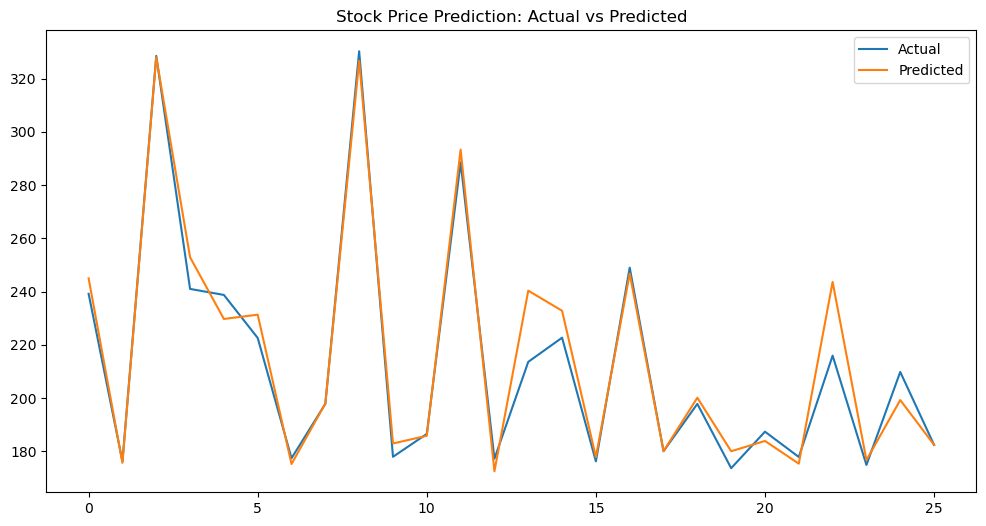

In [1]:
import praw
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE

     #  Scrape Reddit posts
reddit = praw.Reddit(
    client_id="csYgdmmx95x7yqEXWAP_9A",
    client_secret="QoIdO-SmwW05HLB7gzjMfBw6n0ys1Q",
    user_agent="Godilla/v1",
)

subreddit_name = "TSLA"
subreddit = reddit.subreddit(subreddit_name)

posts = []
for post in subreddit.hot(limit=1000):  # Limit for scraping
    posts.append({
        "title": post.title,
        "selftext": post.selftext,
        "score": post.score,
        "num_comments": post.num_comments,
        "created_utc": post.created_utc,
        "url": post.url
    })

df = pd.DataFrame(posts)
df.to_csv("reddit_stocks_posts.csv", index=False)

     #  Data cleaning and processing
df = pd.read_csv("reddit_stocks_posts.csv")
df = df.drop_duplicates(subset="title")  # Remove duplicates
df = df[df["selftext"].notna()]  # Remove rows with no selftext

       # Extract tickers from selftext (assuming only TSLA)
df["tickers"] = "TSLA"
df = df[df["tickers"].apply(len) > 0]  # Keep rows with tickers

            # Save cleaned data
df.to_csv("cleaned_reddit_stocks_posts.csv", index=False)

         # Sentiment Analysis with VADER
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment["compound"]  # Compound score for overall sentiment

df["sentiment_score"] = df["selftext"].apply(lambda x: analyze_sentiment(str(x)))

         # Save sentiment analysis data
df.to_csv("sentiment_reddit_stocks_posts.csv", index=False)

         #   Download Stock Data using Yahoo Finance
ticker = "TSLA"
stock_data = yf.download(ticker, start="2024-01-01", end="2024-11-30")
stock_data["Date"] = stock_data.index

            # Save stock data
stock_data.to_csv("tesla_stock_data.csv", index=False)

        #   Merge Reddit Sentiment and Stock Data
sentiment_data = pd.read_csv("sentiment_reddit_stocks_posts.csv")
stock_data = pd.read_csv("tesla_stock_data.csv")

              # Convert UTC to date
sentiment_data["date"] = pd.to_datetime(sentiment_data["created_utc"], unit="s").dt.date
stock_data["date"] = pd.to_datetime(stock_data["Date"]).dt.date

                      # Merge datasets
merged_data = pd.merge(stock_data, sentiment_data, on="date", how="inner")

                   # Save merged data
merged_data.to_csv("merged_stock_sentiment_data.csv", index=False)

       #   Feature Extraction (Including SMAs)
merged_data['SMA_50'] = merged_data['Close'].rolling(window=50).mean()
merged_data['SMA_200'] = merged_data['Close'].rolling(window=200).mean()

# Drop any rows with NaN values (e.g., from the rolling window calculation)
merged_data = merged_data.dropna(subset=['SMA_50', 'SMA_200'])

      #   Define Features and Target for Prediction
features = merged_data[['Open', 'High', 'Low', 'Volume', 'SMA_50', 'SMA_200', 'sentiment_score']]
target = merged_data['Close'].shift(-1)  # Predict the next day's closing price
target.fillna(0, inplace=True)

          #  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

      #   Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#   Model Training (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

   #   Predictions
y_pred = model.predict(X_test_scaled)

#   Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R²: {r2}")

# Step 13: Plot Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.show()
